# Multiline Merging

**Centroid Pair**
$$x_G = \frac{l_i(a_x+b_x)+l_j(c_x+d_x)}{2(l_i+l_j)}$$

$$y_G = \frac{l_i(a_y+b_y)+l_j(c_y+d_y)}{2(l_i+l_j)}$$

**Generalised Centroid**

$$x_G = \frac{\sum_{i=1}^{n}(l_i(a_{ix}+b_{ix}))}{2\left(\sum_{i=0}^{n}l_i\right)}$$

$$x_G = \frac{\sum_{i=1}^{n}(l_i(a_{iy}+b_{iy}))}{2\left(\sum_{i=0}^{n}l_i\right)}$$

**Find Orientation**

If...

$$\lvert\theta_i-\theta_j\rvert\leq\frac{\pi}{2}$$

then...

$$\theta_r = \frac{l_i\theta_i + l_j\theta_j}{l_i + l_j}$$

else...

$$\theta_r = \frac{l_i\theta_i + l_j\left(\theta_j-\pi\frac{\theta_j}{\lvert\theta_j\rvert} \right)}{l_i + l_j}$$

**Generalised Find Orientation**

Find whether most lines are +/- orientated and flip coords of any which are not.

    - Find diff between every line and line with lowest orientation
    - If any difference is more than pi, then take away 2pi!
    - For any resultant lines where the absolute difference is less than pi/2, apply the correction
    - Then use the simplified formula on the new set of line weights and thetas

_Correction:_

$$\theta = \left(\theta-\pi\frac{\theta}{\lvert\theta\rvert} \right)$$

_Simplified Formula_
$$\theta_r = \frac{\sum_{i=1}^{n}(l_i\theta_i)}{\sum_{i=1}^{n}l_i}$$


---

$$\theta_{\min} = \min{\{\theta_1, \theta_2, \theta_3, \ldots,\theta_n\}}$$

$$\delta\theta_i = \theta_i - \theta_{\min}$$

$$\phi_i =
\begin{cases}
    \delta\theta_i, & \text{if } \delta\theta_i \leq \pi\\
    \delta\theta_i - 2\pi, & \text{if } \delta\theta_i > \pi
\end{cases}$$

$$\theta_i =
\begin{cases}
    \theta_i, & \text{if } \lvert\phi_i\rvert < \frac{\pi}{2}\\
    \theta_i - \pi\frac{\theta_i}{\lvert\theta_i\rvert}, & \text{if } \lvert\phi_i\rvert \geq \pi
\end{cases}$$

_If $\theta_i = 0$, let $\frac{\theta_i}{\lvert\theta_i\rvert} = 1$_

$$\theta_r = \frac{\sum_{i=1}^{n}(l_i\theta_i)}{\sum_{i=1}^{n}l_i}$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (15,10)
import os
import json
import itertools
import multiprocessing as mp
import sys

In [3]:
def line_length(line):
    return ((line[0][0] - line[1][0])**2 + (line[0][1] - line[1][1])**2)**0.5

def multi_find_centroid(lines):
    ls = [line_length(l) for l in lines]
    xs, ys = zip(*[(ls[idx]*(l[0][0] + l[1][0]), ls[idx]*(l[0][1] + l[1][1])) for idx, l in enumerate(lines)])
    
    xG = (sum(xs))/(2 * (sum(ls)))
    yG = (sum(ys))/(2 * (sum(ls)))
    return (xG, yG)

def find_line_orientation(line, degrees=False):
        '''get orientation of a line
        https://en.wikipedia.org/wiki/Atan2
        '''
#         l1 = line_length(((0,0), line[0]))
#         l2 = line_length(((0,0), line[1]))
#         if l2 > l1:
#             line = (line[1], line[0])
        orientation = np.arctan2((line[0][1] - line[1][1]), (line[0][0] - line[1][0]))
        if degrees:
            return math.degrees(orientation)
        return orientation

def point_to_framespace(point, centroid, orientation):
    dXG = (point[1] - centroid[1]) * np.sin(orientation) + (point[0] - centroid[0])*np.cos(orientation)
    dYG = (point[1] - centroid[1]) * np.cos(orientation) - (point[0] - centroid[0])*np.sin(orientation)
    return (dXG, dYG)

def lines_to_framespace(lines, centroid, orientation):
    return [[point_to_framespace(point, centroid, orientation) for point in line] for line in lines]

def point_from_framespace(point, centroid, orientation):
    dx = centroid[0] + np.cos(orientation)*point[0] - np.sin(orientation)*point[1]
    dy = centroid[1] + np.sin(orientation)*point[0] + np.cos(orientation)*point[1]
    return (dx, dy)

def mergable(line1, line2, threshold=np.pi/20):
    """Check if two lines can be merged. Default threshold provides 10% coverage (maybe 20%)"""
    if line1[0] == line1[1] or line2[0] == line2[1]:
        raise ValueError("Lines cannot have the same start and end coordinates.")
    if line1[0] in line2 and line1[1] in line2:
        return False
    orientation_delta = find_orientation_difference(line1, line2)
    if orientation_delta <= threshold:
        return True
    elif (np.pi-orientation_delta) <= threshold:
        return True
    else:
        return False
    
def find_orientation_difference(line1, line2, absolute=True):
    """Find the smallest orientation difference between two lines, """
    if isinstance(line1, WebLine):
        l1_theta = line1.orientation
    else:
        l1_theta = find_line_orientation(line1)
    if isinstance(line2, WebLine):
        l2_theta = line2.orientation
    else:
        l2_theta = find_line_orientation(line2)
    
    a = (l1_theta - l2_theta) % (np.pi*2)
    b = (l2_theta - l1_theta) % (np.pi*2)
#     print(a)
#     print(b)
    out = -a if a < b else b
    if absolute:
        return abs(out)
    else:
        return out

# testline2 = WebLine(new_test_lines[1])
# print(testline)
# print(testline2)
# find_orientation_difference([[1,1],[6,6]], [[6,6],[0,1]])

class MergeError(Exception):
    pass

class WebLine():
    def __init__(self, line, orientation=None, length=None):
        self.line = line
        
        if orientation:
            self.orientation = orientation
        else:
            self.orientation = self.find_orientation()
        
        if length:
            self.length = length
        else:
            self.length = self.find_length()
    
    def __repr__(self):
        return "{0}({1})".format(self.__class__.__name__, self.line)
    
    def __str__(self):
        return "{0}\nLength: {1}\nOrientation: {2}".format(self.line, self.length, self.orientation)
    
    # Implement getitem to allow indexing the line to get out the points easily
    def __getitem__(self, i):
        return self.line[i]
    
#     def __len__(self):
#         return len(self.line)
    
    def find_orientation(self):
        return find_line_orientation(self.line)
    
    def find_length(self):
        return line_length(self.line)
    
#     def find_merge_candidates(self):
#         raise NotImplementedError
    
    def export(self):
        return self.line

def multi_merge_line_segments(lines, dmax_x=None, dmax_y=None, dmax_y_o=None, dmax_y_p=None):
    """Merge line segments using the Tavares & Padliha algorithm"""
    centroid = multi_find_centroid(lines)
    
#     lrmin = 50
    
    # Find orientation
    thetas = []
    lengths = []
    for line in lines:
        if isinstance(line, WebLine):
            thetas.append(float(line.orientation))
            lengths.append(line.length)
        else:
            thetas.append(float(find_line_orientation(line)))
            lengths.append(line_length(line))
    
#     normalised_thetas_old = [t - min(thetas) for t in thetas]
    normalised_thetas = [(t - min(thetas))-2*np.pi if t - min(thetas) > np.pi else t - min(thetas) for t in thetas]
#     corrected_thetas = [thetas[idx] if abs(t) <= np.pi/2 else thetas[idx] - np.pi*(thetas[idx]/abs(thetas[idx])) for idx, t in enumerate(normalised_thetas)]
    corrected_thetas = []
    for idx, t in enumerate(thetas):
        t_orig = thetas[idx]
        if abs(t) <= np.pi/2 or t_orig == 0:
            corrected_thetas.append(t_orig)
        else:
            corrected_thetas.append(t_orig - np.pi * (t_orig/abs(t_orig)))
#     print(corrected_thetas)
#     print(normalised_thetas_old)
    
    thetar = sum([lengths[idx] * t for idx, t in enumerate(corrected_thetas)]) / sum(lengths)
    
#     print(thetar)
    
#     return 0
        
    
    # Transform lines to framespace
    transformed_lines = lines_to_framespace(lines, centroid, thetar)
    # ---
    # Now merge to one list of coordinates
    transformed_points = [item for sublist in transformed_lines for item in sublist]
    
    xs, ys = zip(*transformed_points)
    minx = int(min(xs))
    maxx = int(max(xs))
#     miny = int(min(ys))
#     maxy = int(max(ys))        
#     l1_X_G = abs(transformed_lines[0][1][0] - transformed_lines[0][0][0])
#     l2_X_G = abs(transformed_lines[1][1][0] - transformed_lines[1][0][0])

    lr = maxx - minx
    
# #     if lr < lrmin:
# #         raise MergeError("Line too small.")
    
#     # Set working dmax_y value to the same as dmax_y. If dmax_y is also None then it doesn't matter.
#     dmax_y_working = dmax_y
# #     print("dmax_x = {}".format(dmax_x))
    
#     if lr >= (l1_X_G + l2_X_G):
#         # Not Overlapping!
# #         print("Not Overlapping!")
#         # Test dmax_x only in the case that candidate lines are not overlapping
#         if dmax_x is not None:
#             if (lr - (l1_X_G + l2_X_G)) > dmax_x:
#                 raise MergeError("X distance outside maximum threshold value. {} > {}".format((lr - (l1_X_G + l2_X_G)), dmax_x))            
                

#     elif np.isclose(lr, l1_X_G) or np.isclose(lr, l2_X_G):
#         # Here we use isclose rather than == due to minor rounding errors when transforming to framespace
#         # Fully Overlapping!
# #         print("Fully Overlapping!")
#         # If dmax_y for overlapping has been specified, use that, otherwise leave as normal dmax_y
#         if dmax_y_o is not None:
#             dmax_y_working = dmax_y_o

#     elif lr < (l1_X_G + l2_X_G):
#         # Partially Overlapping!
# #         print("Partially Overlapping!")
#         # If dmax_y for partial has been specified, use that, otherwise leave as normal dmax_y
#         if dmax_y_p is not None:
#             dmax_y_working = dmax_y_p
#     else:
#         print("Inconclusively Overlapping.")
#         raise MergeError("Overlap of lines could not be conclusively evaluated.")
    
# #     print("dmax_x = {}, dmax_y = {}".format(dmax_x, dmax_y_working))
#     if dmax_y_working is not None:
#         if abs(maxy - miny) > dmax_y_working:
#             raise MergeError("Y distance outside maximum threshold value. {} > {}".format(abs(maxy - miny), dmax_y_working))
    
    # Retransform min and max values back to normal space
    merged_line = WebLine([point_from_framespace((minx, 0), centroid, thetar),point_from_framespace((maxx, 0), centroid, thetar)], thetar, lr)
#     merged_line = (point_from_framespace((minx, 0), centroid, thetar),point_from_framespace((maxx, 0), centroid, thetar))
    return merged_line

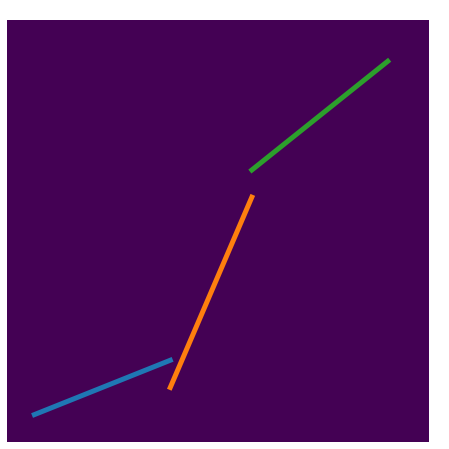

In [4]:
test_lines = (
    ((1, 2), (4, 5)),
    ((2, 1), (5, 3)),
    ((2, 1), (5, 3)),
)

test_lines = (
    ((1,1), (6,3)),
    ((6,2), (9,9)),
    ((9,10), (14,14)),
)

test_lines = (
    ((6,3), (1,1)),
    ((6,2), (9,9)),
    ((9,10), (14,14)),
)

# test_lines = (((1,1), (6,3)), ((6,2), (9,9)))

demofig = np.full((16,16), 0, dtype=np.uint8)
fig,ax = plt.subplots(1, figsize=(8,8))
ax.imshow(demofig)
for line in test_lines:
    p0, p1 = line
    ax.plot((p0[0], p1[0]), (p0[1], p1[1]), lw=5)
# ax.plot((new_merged_line[0][0], new_merged_line[1][0]), (new_merged_line[0][1], new_merged_line[1][1]), lw=2, ls='--')
ax.set_xlim((0, demofig.shape[1]))
ax.set_ylim((0, demofig.shape[0]))

ax.axis('off')
plt.show()

In [5]:
ls = [line_length(l) for l in test_lines]
[(ls[idx]*(l[0][0] + l[1][0]), ls[idx]*(l[0][1] + l[1][1])) for idx, l in enumerate(test_lines)]

[(37.69615364994153, 21.540659228538015),
 (114.23659658795863, 83.773504164503),
 (147.27185746095552, 153.67498169838836)]

In [6]:
test_centroid = multi_find_centroid(test_lines)
print(test_centroid)

(7.709844603136507, 6.673580590589719)


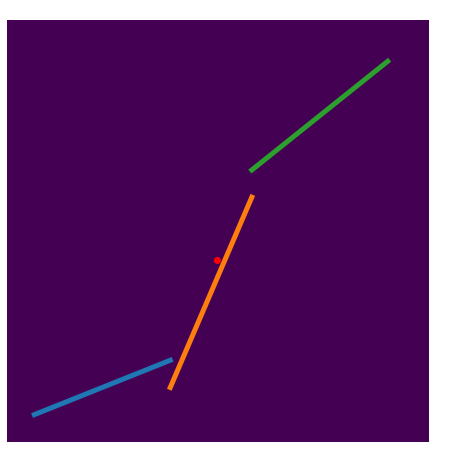

In [7]:
demofig = np.full((16,16), 0, dtype=np.uint8)

fig,ax = plt.subplots(1, figsize=(8,8))
ax.imshow(demofig)
for line in test_lines:
    p0, p1 = line
    ax.plot((p0[0], p1[0]), (p0[1], p1[1]), lw=5)
ax.plot(*test_centroid, 'ro')
ax.set_xlim((0, demofig.shape[1]))
ax.set_ylim((0, demofig.shape[0]))

ax.axis('off')
plt.show()

In [8]:
merged_line = multi_merge_line_segments(test_lines)

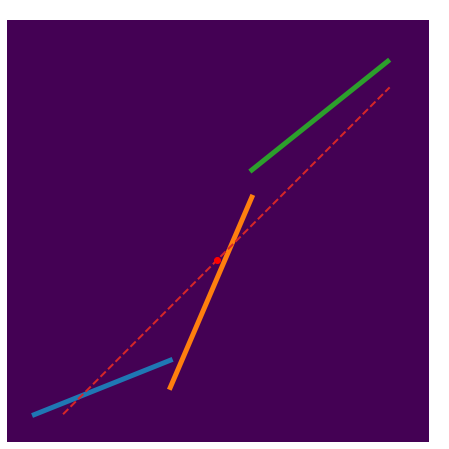

In [9]:
demofig = np.full((16,16), 0, dtype=np.uint8)

fig,ax = plt.subplots(1, figsize=(8,8))
ax.imshow(demofig)
for line in test_lines:
    p0, p1 = line
    ax.plot((p0[0], p1[0]), (p0[1], p1[1]), lw=5)
ax.plot((merged_line[0][0], merged_line[1][0]), (merged_line[0][1], merged_line[1][1]), lw=2, ls='--')
ax.plot(*test_centroid, 'ro')
ax.set_xlim((0, demofig.shape[1]))
ax.set_ylim((0, demofig.shape[0]))

ax.axis('off')
plt.show()

## Fun Tester

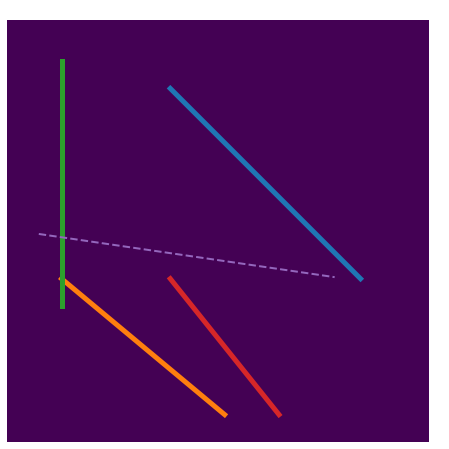

In [26]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

rng = np.random.default_rng()
coords = rng.integers(1, 15, size=16)

new_test_lines = [x for x in chunks([x for x in chunks(coords, 2)],2)]
new_merged_line = multi_merge_line_segments(new_test_lines)

demofig = np.full((16,16), 0, dtype=np.uint8)
fig,ax = plt.subplots(1, figsize=(8,8))
ax.imshow(demofig)
for line in new_test_lines:
    p0, p1 = line
    ax.plot((p0[0], p1[0]), (p0[1], p1[1]), lw=5)
ax.plot((new_merged_line[0][0], new_merged_line[1][0]), (new_merged_line[0][1], new_merged_line[1][1]), lw=2, ls='--')
ax.set_xlim((0, demofig.shape[1]))
ax.set_ylim((0, demofig.shape[0]))

ax.axis('off')
plt.show()

In [10]:
test_lines = (
    ((1, 2), (4, 5)),
    ((2, 1), (5, 3))
)
%timeit -n 1000 -r 1000 new_merged_line = multi_merge_line_segments(test_lines)

42.3 µs ± 5.53 µs per loop (mean ± std. dev. of 1000 runs, 1000 loops each)


**14/02/20**

Update: so we can now merge MULTIPLE line segments. As such if we can come up with a way to group candidate lines together, we can merge them as necessary without worrying about how to merge them recursively. This generalised algorithm provides the same result as the original for any 2 given starting lines (though I have not yet checked to see how much of a speed penalty the generalised algorithm suffers from).

_The generalised algorithm still does not have thresholds implemented, but that can be done._

In [27]:
def gen_lines(n):
    coords_n = n*4
    coords = rng.integers(1, 100, size=coords_n)
    return [x for x in chunks([x for x in chunks(coords, 2)],2)]

In [28]:
new_test_lines = gen_lines(100)
%timeit -n 1 -r 1 new_merged_line = multi_merge_line_segments(new_test_lines)

3.17 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Notes 18/02/20
1. Manual polar transform and check
2. Polar coordinate optimiser to optimise for hub location
3. Ellipse fitting/optimisation
    - For each ellipse test
        - Create ellipse
        - Transform image such that ellipse is now circle
        - Polar unwrap image
        - Test to see how many lines are mostly horiz or vert <- **This is our reward function**
        
Run multi_find_centroid on ALL lines to find a starting point.
Translation to whole image based upon the coordinates of the candidate midpoint to make that at 0,0 then do an inverse polar coordinate transformation

In [29]:
class WebKernel():
    def __init__(self, webdict=None):
        if webdict:
            self.webdict = webdict
            self.lines = [WebLine(x) for x in self.webdict["lines"]]
            self.dimensions = self.webdict.get("dimensions", self.find_dimensions())
            self.remove_zero_lines()
        else:
            self.webdict = dict()
            self.lines = []
            self.dimensions = []
    def __len__(self):
        return len(self.lines)
    
    def __getitem__(self, i):
        return self.lines[i]
    
    def __str__(self):
        if len(self.lines):
            return "Web Kernel of {0} lines, ({1}x{2})".format(len(self.lines), *self.dimensions)
        else:
            return "Empty Web Kernel"
    
    def __repr__(self):
        return "{0}({1})".format(self.__class__.__name__, self.webdict)

    def find_dimensions(self):
        """Find minimum dimensions of a web kernel"""
        flattened = [item for sublist in self.lines for item in sublist]
        xs, ys = zip(*flattened)
        dimx = int(max(xs))
        dimy = int(max(ys))
        return [dimx, dimy]
    
    def remove_zero_lines(self):
        self.lines = [x for x in self.lines if x.length > 0]
    
    def find_merge_candidates(self):
        candidates = list(itertools.combinations(self.lines, 2))
        print(len(candidates))
        candidates = [c for c in candidates if mergable(*c)]
        print(len(candidates))
        return candidates
#         print(len(candidates))
        # Find all pairings
    
    def as_dict(self):
        """Export a Web Kernel as a dictionary"""
        return {"dimensions": self.dimensions, "lines": [line.export() for line in self.lines]}


with open(os.path.join("../data/full_web_kernel.json"), "r") as f:
    web_dict = json.load(f)

webpack = WebKernel(web_dict)

In [30]:
full_centroid = multi_find_centroid(webpack)

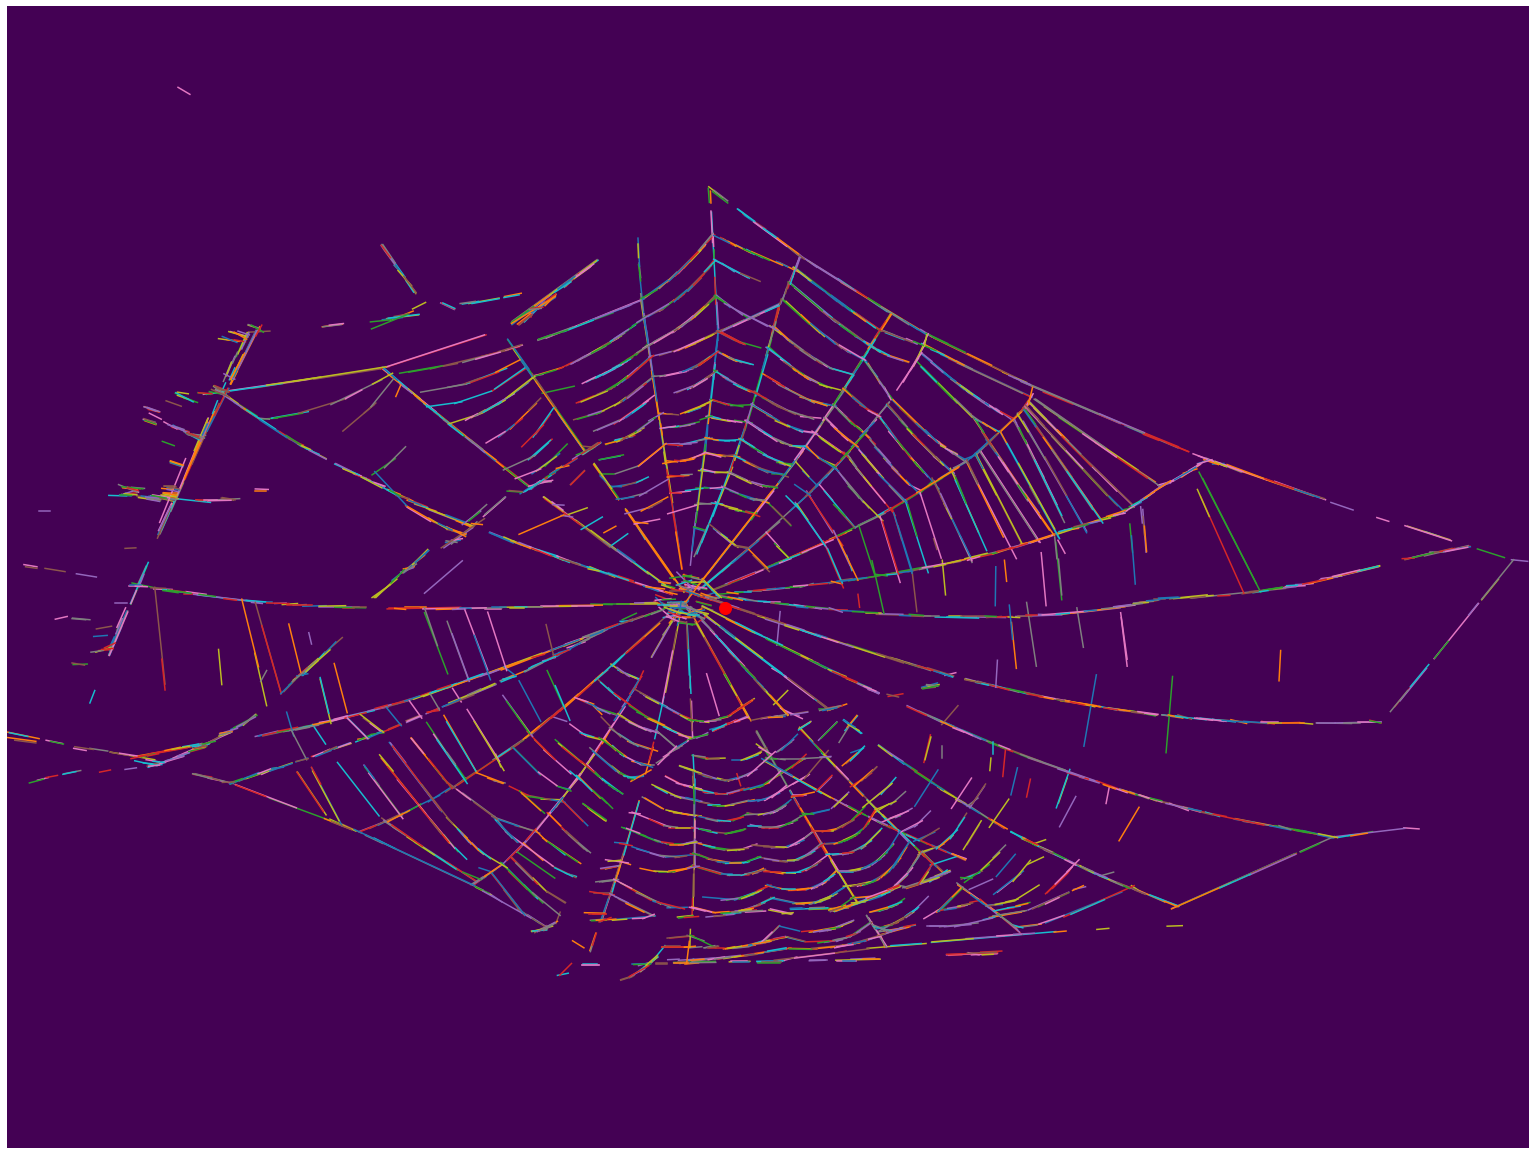

In [31]:
demofig = np.full(webpack.dimensions[::-1], 0, dtype=np.uint8)
fig,ax = plt.subplots(1, figsize=[int(d/100) for d in webpack.dimensions])
ax.imshow(demofig)

for line in webpack.lines:
    p0, p1 = line
    ax.plot((p0[0], p1[0]), (p0[1], p1[1]))
ax.plot(*full_centroid, 'ro', markersize=12)
ax.set_xlim((0, demofig.shape[1]))
ax.set_ylim((demofig.shape[0], 0))
ax.axis('off')
plt.show()